### OSM network cleaning

In order to run the typological structuring (`postgis_topology`) module in Postgis, we need to provide a sound input for the `level` values. The OSM data contains unhasahble lists that need cleaning before we can assig the right values.

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gp
import osmnx as ox
from shapely import wkt, wkb
import sys
import psycopg2
from shapely.geometry import Point, Polygon, LineString, MultiLineString, MultiPolygon

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

#paths
PATH_TO_DATA_FOLDER = '../data/'

In [24]:
# https://boundingbox.klokantech.com/
# bbox = min Longitude , min Latitude , max Longitude , max Latitude
bbox_ams_4326 = [4.780453, 52.29726, 5.020436, 52.427875]
bbox_ams_osm = [52.427875, 52.29726, 5.020436, 4.780453] # N, S, E, W 

In [25]:
G = ox.graph_from_bbox(bbox_ams_osm[0], bbox_ams_osm[1], bbox_ams_osm[2], bbox_ams_osm[3], 
                       simplify=True, network_type='all', name='Amsterdam')

In [54]:
crs_init = {'init' : 'epsg:4326'}
df_nodes, df_edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [55]:
df_edges = df_edges.rename(columns ={'highway': 'fclass'})

# clean up fclass
df_edges['fclass'] = \
[row[0] if isinstance(row, list) and row[0] != 'unclassified' else \
 row[1] if isinstance(row, list) and row[1] != 'unclassified' else \
 row for row in df_edges.fclass]

# clean up bridge
df_edges['bridge'] = ['viaduct' if isinstance(row, list) and row[0] != 'viaduct' else \
 'movable' if isinstance(row, list) and row[1] != 'movable' else \
 row for row in df_edges.bridge]

# clean up tunnel
df_edges['tunnel'] = ['building_passage' if isinstance(row, list) and \
                      row[0] != 'building_passage' else \
                      row for row in df_edges.tunnel]
df_edges['tunnel'] = [np.nan if isinstance(row, list) else row for row in df_edges.tunnel]
# correct tunnel = no assign np.nan
df_edges.loc[df_edges.tunnel == 'no', 'tunnel'] = np.nan

In [56]:
# filter out motorways/ ring
df_edges = df_edges.query("fclass != 'motorway_link' and fclass != 'motorway'")

**level assignment **

In [57]:
# levels to be put on -1
level_minus = df_edges.tunnel.value_counts().keys().tolist()
# levels to be put on 1
level_plus = df_edges.bridge.value_counts().keys().tolist()

df_edges['level'] = 0
# assign level -1 to tunnels
df_edges.loc[df_edges.tunnel.isin(level_minus), 'level'] = -1
# assign level 1 to bridges
df_edges.loc[df_edges.bridge.isin(level_plus), 'level'] = 1

In [58]:
# convert to 28992
crs_convert = {'init': 'epsg:28992'}
df_edges['geometry'] = df_edges['geometry'].to_crs(crs_convert)

drop_cols =['u', 'v']
for col in drop_cols:
    df_edges = df_edges.drop(col, axis=1)

In [59]:
# to crs 28992, overwrite x, y values 
df_nodes['geometry'] = df_nodes['geometry'].to_crs(epsg=28992)
df_nodes['x'] = df_nodes.geometry.x
df_nodes['y'] = df_nodes.geometry.y

In [46]:
# write to csv, store in data folder
df_edges.to_csv(PATH_TO_DATA_FOLDER + 'df_edges_ams.csv', index=False, sep=',')
df_nodes.to_csv(PATH_TO_DATA_FOLDER + 'df_nodes_ams.csv', index=False, sep=',')

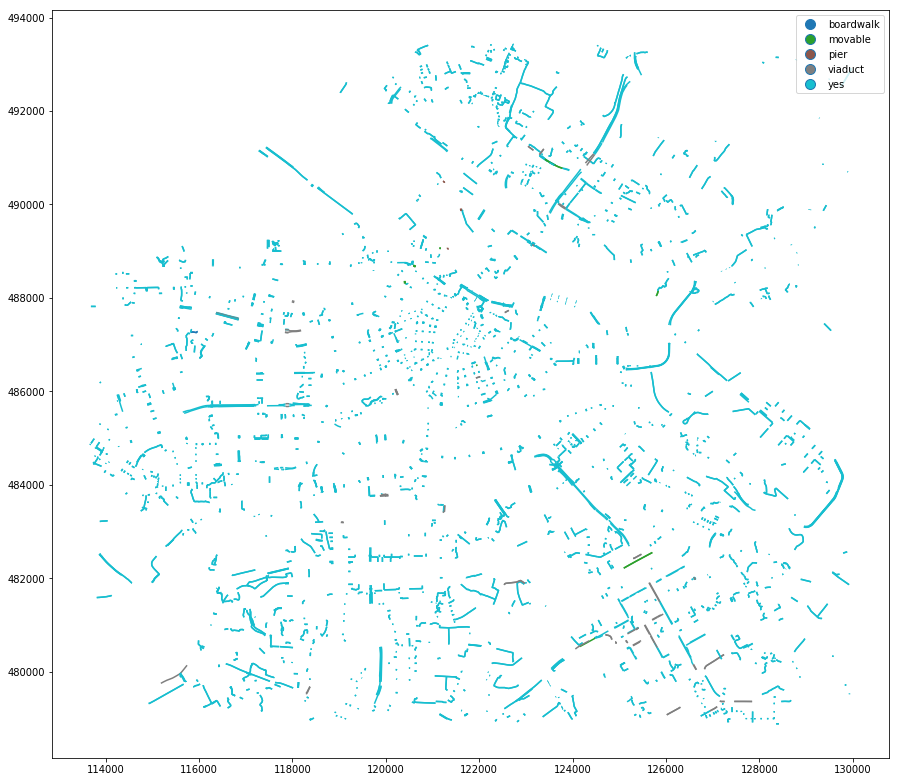

In [60]:
# level 1
f, ax = plt.subplots(figsize=[15,15])
df_edges.query("level == 1").plot(ax=ax, column = 'bridge', legend=True)

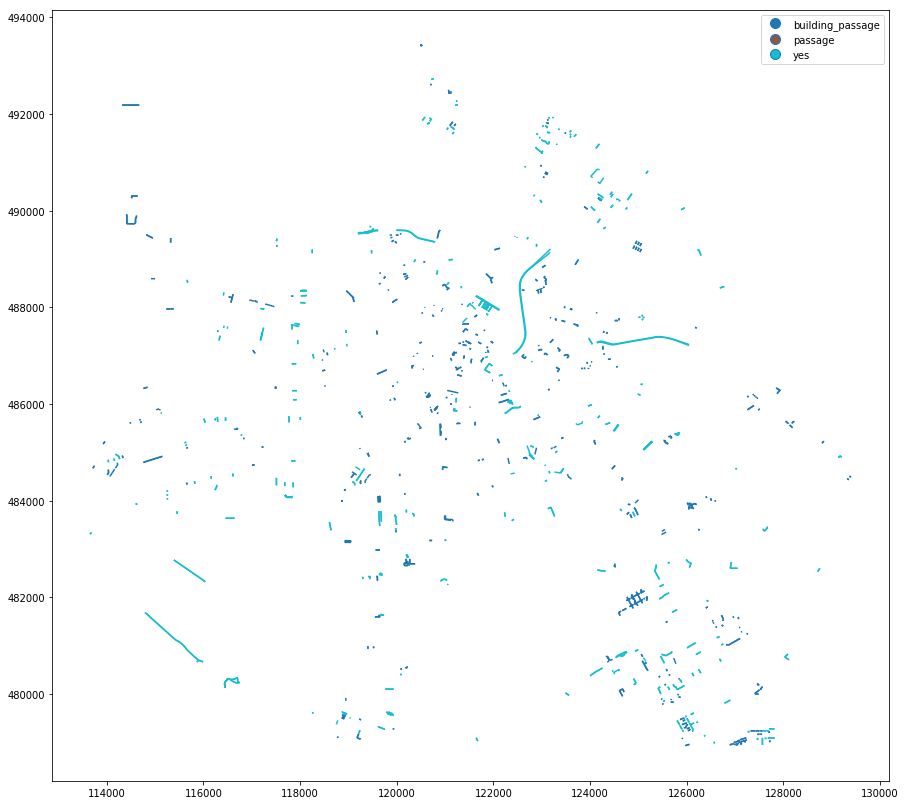

In [61]:
# level -1
f, ax = plt.subplots(figsize=[15,15])
df_edges.query("level == -1").plot(ax=ax, column = 'tunnel', legend=True)

### load to postgres

In [14]:
sys.path.insert(0, '../helper_functions/')
from config_postgresql import config, postgres_engine_pandas, load_csv_to_postgres

the `load_csv_to_postgres` function (see helper_functions folder for code) will probably take a long time if your postgres db instance is remote. psql comes to the rescue:

Store following command in a text editor and save as `import_df_nodes.sql` in the same folder as your stored csv you want to copy from:

```
\out import_df_nodes_ams.log

truncate table osm.df_nodes_ams;
\copy osm.df_nodes_ams (highway, osmid, ref, x, y, geometry) from 'df_nodes_ams.csv' WITH CSV HEADER DELIMITER AS ',' quote as '"' escape as '\';
```

then read from cli (provided your password)
```
psql -h 89.31.99.70 -U dataservice -d dataservice -p 8080 -f import_df_nodes.sql
```

Same for `import_df_nodes.sql` that should contain: 

```
\out import_df_edges_ams.log

truncate table osm.df_edges_ams;
\copy osm.df_edges_ams (area, bridge, geometry, fclass, junction, key, lanes, "length", "level", maxspeed, maxweight, name, oneway, osmid, "ref", service, tunnel) from 'df_edges_ams.csv' WITH CSV HEADER DELIMITER AS ',' quote as '"' escape as '\';
```

that can be kicked off from cli:
```
psql -h 89.31.99.70 -U dataservice -d dataservice -p 8080 -f import_df_edges.sql
```

It takes not even 10 seconds to write the tables to Postgis that recognizes the right datatypes and converts geometries accordingly.

In [70]:
# load_csv_to_postgres(datadir=PATH_TO_DATA_FOLDER, filename='df_edges_ams.csv',
#                     table_name= 'df_edges_ams',
#                     schema = 'osm',
#                     config_path = '../config.ini',
#                     config_name = 'postgresql', all_csv=False)

In [71]:
# load_csv_to_postgres(datadir=PATH_TO_DATA_FOLDER, filename='df_nodes_ams.csv',
#                     table_name= 'df_nodes_ams',
#                     schema = 'osm',
#                     config_path = '../config.ini',
#                     config_name = 'postgresql', all_csv=False)